
### Import Modules


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from sklearn.model_selection import train_test_split
import random

import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

from livelossplot import PlotLossesKerasTF

from utils import set_plotting_context
from DescatteringAutoencoder import Descattering_Autoencoder

plt.style.use("ggplot")

%reload_ext autoreload
%autoreload 2


## Loading the Training Data


<p>Assume training data as numpy-file called Train.npz in folder named ./data/.</p>
<p>The file should contain the me-emsc coorrected spectra, the raw-spectra and the corresponding wavenumbers. The wavenumber region considered must be adjusted to be compatible with the size of the neural network. For the default settings of the Descattering Autoencoder, a 1408 dimensional wavenumber dimension fits.</p>

In [9]:
data_path = "./data/"
data = np.load(data_path + "Train.npz")

wn_dim = 1408
memsc, raw, wn = data["memsc"][:, :wn_dim], data["raw"][:, :wn_dim], data["wn"][:wn_dim]
memsc_train, memsc_val, raw_train, raw_val = train_test_split(memsc, raw, test_size=0.15)


### Defining the Cost Function


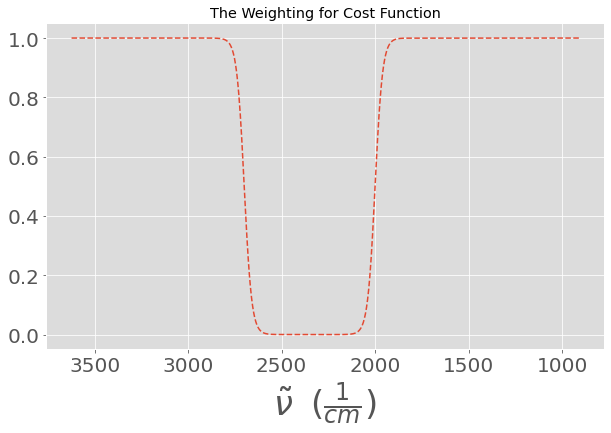

In [10]:
def weight_function(wn, kappa=0.025, wn_start=2000, wn_end=2700):
    return np.squeeze(1 + np.tanh(kappa*(wn - wn_end))/2 - np.tanh(kappa*(wn - wn_start))/2 )

def weighted_loss(y_pred, y_true):
    mse = K.mean(K.square(y_true - y_pred), axis=1)
    mae = K.mean(K.abs(y_true - y_pred), axis=1)
    lam = 1  
    return mae + mse * (1 + lam * weight_function(wn))

set_plotting_context(ylabel="")
plt.plot(wn, weight_function(wn, kappa=0.025), "--")
plt.title("The Weighting for Cost Function")
plt.show()


### Initializing and Compiling the DSAE


In [19]:
spectral_input = Input(shape=(wn_dim, 1),
                   name="Input_Spectrum")

DSAE = Model(inputs=spectral_input, 
             outputs=Descattering_Autoencoder(spectral_input,
                                              l2_reg=0.001))

DSAE.compile(loss=weighted_loss, 
             optimizer=RMSprop(lr=0.0001),
             metrics=["mean_squared_error", "mean_absolute_error"])

DSAE.summary(line_length=90)

Model: "functional_13"
__________________________________________________________________________________________
Layer (type)                            Output Shape                        Param #       
Input_Spectrum (InputLayer)             [(None, 1408, 1)]                   0             
__________________________________________________________________________________________
Conv_1 (Conv1D)                         (None, 1408, 32)                    768           
__________________________________________________________________________________________
BatchNorm_1 (BatchNormalization)        (None, 1408, 32)                    128           
__________________________________________________________________________________________
ReLU_1 (Activation)                     (None, 1408, 32)                    0             
__________________________________________________________________________________________
Pooling_1 (AveragePooling1D)            (None, 704, 32)            

In [35]:
# Load Weights from File
DSAE.load_weights('weights/DSAE_weights.hdf5')

### Training the Model

In [ ]:
save_best = ModelCheckpoint('weights/DSAE_best_weights.hdf5', 
                            save_best_only=True, 
                            monitor='val_loss', 
                            mode='min')

DSAE.fit(
        x = raw_train[:,:,np.newaxis], 
        y = memsc_train[:,:,np.newaxis], 
        validation_data = (raw_val[:,:,np.newaxis], memsc_val[:,:,np.newaxis]),
        callbacks = [PlotLossesKerasTF(), save_best], 
        batch_size = 128,
        epochs = 250,
        verbose = False
        )


## Comparing DSAE to ME-EMSC


In [36]:
DSAE_val = DSAE.predict(raw_val[:,:, np.newaxis])

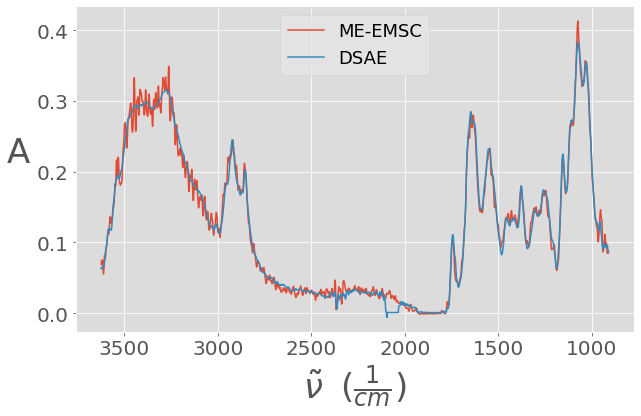

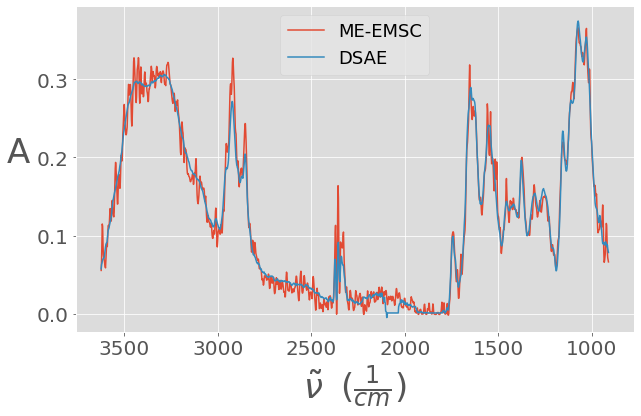

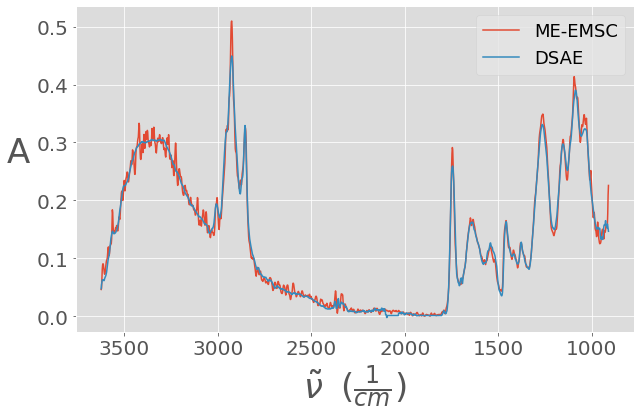

In [57]:
N = 3
for _ in range(N):
    set_plotting_context()
    idx = random.randint(0, memsc_val.shape[0])
    plt.plot(wn, memsc_val[idx], label="ME-EMSC")
    plt.plot(wn, DSAE_val[idx], label="DSAE")
    plt.legend(fontsize=18)
    plt.show()


## Test on Image


<p>Assume a .mat file called Hyperspectral_6_1.mat is found in the folder named ./data/. The file should contain the raw hyperspectral image under the key "rawSpec".</p>

In [41]:
mat = scipy.io.loadmat(data_path + 'Hyperspec_6_1.mat')
raw_im = mat["rawSpec"][:, :wn_dim]
DSAE_im = DSAE.predict(raw_im[:,:, np.newaxis])
im_Nx, im_Ny = 128, 128

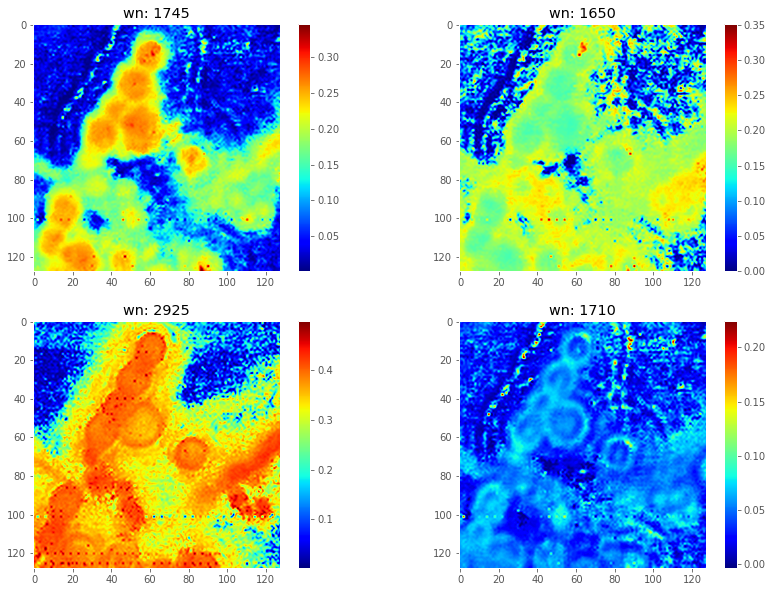

In [55]:
fig, axs = plt.subplots(figsize=(14,10), nrows=2, ncols=2)
axs = axs.flatten()
wn_plotting_list = [1745, 1650, 2925, 1710]

for ax, wn_implot in zip(axs, wn_plotting_list):
    wn_idx = np.argmin(np.abs(wn - wn_implot))

    a = ax.imshow(DSAE_im.reshape(im_Nx, im_Ny, -1)[:, :, wn_idx], 
                  cmap="jet", 
                  interpolation="lanczos")
    ax.grid(False)
    ax.set_title(f"wn: {wn_implot}")
    fig.colorbar(a, ax=ax)
plt.show()